# Practise YOLOv5

## Import Libraries

In [ ]:
# Libraries to load and analyze data
import os
import tarfile
import urllib.request
import glob
import numpy as np
import shutil
import pandas as pd
import xml.etree.ElementTree as ET
from sklearn import preprocessing
from time import time
from tqdm import tqdm

# Libraries to work with images and build models
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from PIL import Image, ImageDraw
from albumentations import (HorizontalFlip, ShiftScaleRotate, VerticalFlip, Normalize,Flip,
                            Compose, GaussNoise)
import cv2
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython.display import display

device = 'cpu'
print(f'Using device: {device}')

dataset_path = 'data/VOCdevkit/VOC2012/'

Using device: mps


## Load Annotations

Loading only annotations for the images made in the year 2010 as pandas DataFrame.

In [88]:
def xml_to_csv(path=dataset_path+'Annotations/'):
    xml_list = []
    for xml_file in tqdm(glob.glob(path + '/2010*.xml')):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for obj in root.findall('object'):
            bbx = obj.find('bndbox')
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            label = obj.find('name').text

            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[2].text),
                     int(root.find('size')[1].text),
                     label,
                     xmin,
                     ymin,
                     xmax,
                     ymax
                     )
            xml_list.append(value)
    column_name = ['filename', 'channels', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [89]:
xml_df = xml_to_csv()
xml_df.to_csv('VOC_2010.csv', index=None)
print('Saved as csv file.')

100%|██████████| 3503/3503 [00:00<00:00, 5170.68it/s]


Saved as csv file.


For easier troubleshooting I keep only the top 100 objects.

In [ ]:
xml_df = xml_df[:100]

In [91]:
xml_df.head()

,filename,channels,width,height,class,xmin,ymin,xmax,ymax
0,2010_005054.jpg,3,500,111,tvmonitor,86,34,121,70
1,2010_005054.jpg,3,500,111,sofa,318,42,427,111
2,2010_005054.jpg,3,500,111,sofa,1,70,98,111
3,2010_005732.jpg,3,500,375,cat,181,1,500,375
4,2010_003343.jpg,3,500,375,sheep,68,122,264,232


In [92]:
print(f'Oveall number of objects: {xml_df.shape[0]}')
print(f'Number of images in the dataframe: {len(np.unique(xml_df["filename"]))}')

Oveall number of objects: 200
Number of images in the dataframe: 91


## Data Preparation

Encode object classes with `LabelEncoder`.

In [93]:
le = preprocessing.LabelEncoder()
xml_df['class'] = le.fit_transform(xml_df['class'])
xml_df.head()

,filename,channels,width,height,class,xmin,ymin,xmax,ymax
0,2010_005054.jpg,3,500,111,18,86,34,121,70
1,2010_005054.jpg,3,500,111,16,318,42,427,111
2,2010_005054.jpg,3,500,111,16,1,70,98,111
3,2010_005732.jpg,3,500,375,7,181,1,500,375
4,2010_003343.jpg,3,500,375,15,68,122,264,232


Save the encoding as dictionary in the `mappring` variable

In [94]:
class_to_id_mapping = dict(zip(le.classes_, range(len(le.classes_))))
class_to_id_mapping

{'aeroplane': 0,
 'bicycle': 1,
 'bird': 2,
 'boat': 3,
 'bottle': 4,
 'bus': 5,
 'car': 6,
 'cat': 7,
 'chair': 8,
 'diningtable': 9,
 'dog': 10,
 'horse': 11,
 'motorbike': 12,
 'person': 13,
 'pottedplant': 14,
 'sheep': 15,
 'sofa': 16,
 'train': 17,
 'tvmonitor': 18}

Now we need to convert our data to the **YOLOv5** format.

The annotation for each object should contain the following information:

`Class X Y Width Height`

For this, we'll use the helper function `convert_to_yolov5`.

In [95]:
def convert_to_yolov5(df, unique_img_names):
    df_array = np.array(df)

    # For each unique image name
    for unique_img_name in unique_img_names:
        print_buffer = []

        # For each object
        for i in range(len(df)):
            point =  df_array[i]
            img_name = point[0]

            if img_name == unique_img_name:
                class_id = point[4]

                # Transform bbox coordinates
                X = (point[5] + point[7]) / 2
                Y = (point[6] + point[8]) / 2
                Width = (point[7] - point[5])
                Height = (point[8] - point[6])

                # Normalize coordinates
                image_w, image_h = point[2], point[3]
                X /= image_w
                Y /= image_h
                Width /= image_w
                Height /= image_h
              
                # Save the bbox information to the buffer
                print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, X, Y, Width, Height))

        # Get file names to save the annotation
        save_file_name = os.path.join(dataset_path+'JPEGImages/yolov5/labels/', unique_img_name.replace("jpg", "txt"))
        # Save the annotations to disk
        print("\n".join(print_buffer), file=open(save_file_name, "w"))
        # Copy the image to the new folder                
        shutil.copy(dataset_path+'JPEGImages/'+unique_img_name, dataset_path+'JPEGImages/yolov5/images/'+unique_img_name)


In [96]:
# First let's get the unique image names
unique_img_names = xml_df['filename'].unique()
print('Unique image names number: ', len(unique_img_names))

Unique image names number:  91


In [97]:
# Then we convert the annotations to YOLOv5 format
convert_to_yolov5(xml_df, unique_img_names)

Let's test the transformed annotations via a viaualization.

In [98]:
id_to_class_mapping = dict(zip(class_to_id_mapping.values(), class_to_id_mapping.keys()))
id_to_class_mapping

{0: 'aeroplane',
 1: 'bicycle',
 2: 'bird',
 3: 'boat',
 4: 'bottle',
 5: 'bus',
 6: 'car',
 7: 'cat',
 8: 'chair',
 9: 'diningtable',
 10: 'dog',
 11: 'horse',
 12: 'motorbike',
 13: 'person',
 14: 'pottedplant',
 15: 'sheep',
 16: 'sofa',
 17: 'train',
 18: 'tvmonitor'}

In [99]:
def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size

    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)), outline="#FF0000FF", width=2)

        plotted_image.text((x0, y0 - 10), id_to_class_mapping[(int(obj_cls))], fill="#000")
    
    
    plt.imshow(np.array(image))
    plt.show()

In [ ]:
# Pick a random annotation file 
annotation_random = !ls {dataset_path}/JPEGImages/yolov5/*txt | gshuf -n 1
annotation_random

['zsh:1: no matches found: data/VOCdevkit/VOC2012//JPEGImages/convert_to_yolov5/*txt']

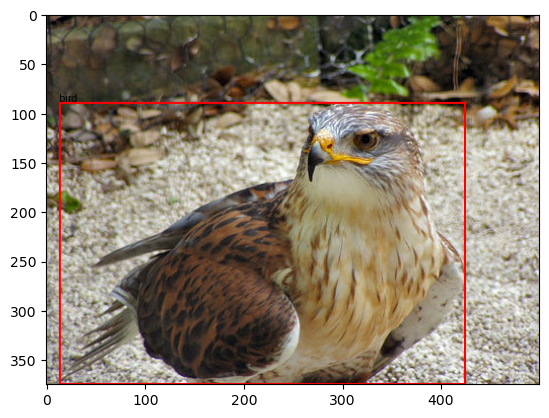

In [15]:
# Load random annotation file
annotation_file = annotation_random[0]
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("txt", "jpg")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

Trained model is available in the `hub` class of the `torch` library.

Let's see what would be the model predictions for our random image.

In [16]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')
model.model.to(device)
print(next(model.model.parameters()).device)
img = annotation_random[0].replace("txt", "jpg")

# Inference
results = model(img)

# Results
results.print()

Using cache found in /Users/dmitriygolubitskiy/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-10-18 Python-3.11.11 torch-2.7.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/Users/dmitriygolubitskiy/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


mps:0


image 1/1: 375x500 1 bird
Speed: 72.4ms pre-process, 212.8ms inference, 79.6ms NMS per image at shape (1, 3, 480, 640)


## Train YOLOv5

Train the **yolov5** model using the prepared `train.py` file from the repository https://github.com/ultralytics/yolov5.git.

For this model, images and object classes should be located in the images and labels folders, respectively.

Test the model on the validation set and display the resulting images with bbox and object classes.

I will use the `coco128` dataset and a predefined YOLOv5 Medium size model with weights.

Not to overload the machine, I am using a small batch of 4 images.

In [2]:
!python train.py --img 640 --batch 4 --epochs 10 --data coco128.yaml --weights yolov5m.pt --cache

train: weights=yolov5m.pt, cfg=, data=coco128.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=4, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 2025-10-15 Python-3.12.8 torch-2.4.1 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0

The model has achieved the mAP=0.86 after 10 training epochs, which is a very good result.

Here is a summary of metrics for training and validation:
![Training and validation results](results.png)

Here some images with boxes and class labels from the validation process:

Image 1
![Image 1](val_batch0_pred.jpg)

Image 2
![Image 2](val_batch1_pred.jpg)

Image 3
![Image 3](val_batch2_pred.jpg)
